In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text,ax_text

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
plt.style.use('../../assets/stylesheets/soc_base.mplstyle')
plt.rcParams['font.family'] = 'DM Sans'

In [3]:
data = pd.read_csv('../../data/soc/serie_a_touches.csv',index_col=0)

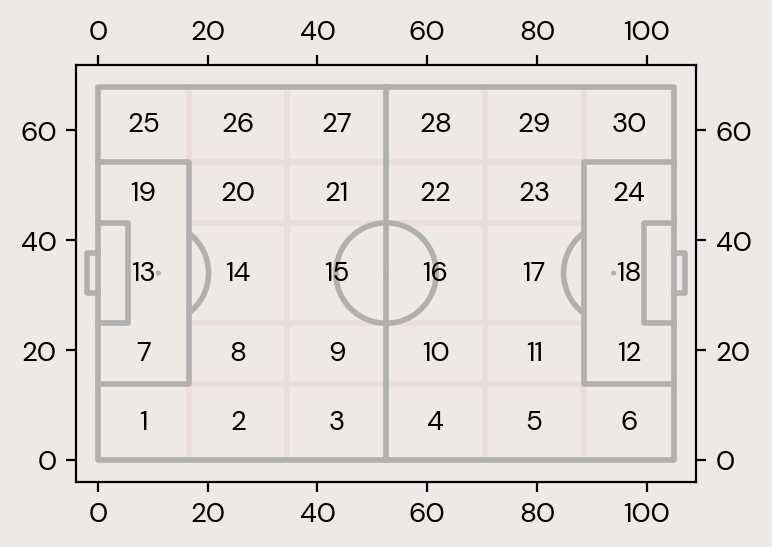

In [4]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(111)
pitch = Pitch(
    pitch_type='uefa',
    half=False,
    axis=True,
    label=True,
    tick=True,
    goal_type='box',
    positional=True
)
pitch.draw(ax=ax)

pos_x = pitch.dim.positional_x
pos_y = pitch.dim.positional_y

counter = 1

for index_y, y in enumerate(pos_y):
    for index_x, x in enumerate(pos_x):
        try:
            label_y = (pos_y[index_y]+pos_y[index_y+1])/2
            label_x = (pos_x[index_x]+pos_x[index_x+1])/2
        except:
            continue
        ax.annotate(
            xy=(label_x,label_y),
            text=counter,
            ha='center',
            va='center'
        )
        counter += 1


In [5]:
test_df = data[data['team'] == 'Napoli']
test_df.head()

color_team = '#78D3F2'
color_opp = '#DC3A44'
color_cont = '#D3D3D3'


In [6]:
def plot_zone_dominance(ax, team_id):
    filtered_df = data[data['team_id'] == team_id].copy()
    pitch = Pitch(
        pitch_type='uefa',
        goal_type='box',
        linewidth=1.1,
        line_color='black',
        pad_top=10,
        corner_arcs=True
    )
    pitch.draw(ax=ax)

    # Here we can get the positional dimensions
    pos_x = pitch.dim.positional_x
    pos_y = pitch.dim.positional_y

    # We test the dimensions with the labels we got from the Analyst
    counter = 1
    filtered_df['zone'] = filtered_df['zone'].astype(int)
    for index_y, y in enumerate(pos_y):
        for index_x, x in enumerate(pos_x):
            try:
                label_y = (pos_y[index_y] + pos_y[index_y + 1])/2
                label_x = (pos_x[index_x] + pos_x[index_x + 1])/2
                lower_y = pos_y[index_y]
                lower_x = pos_x[index_x]
                upper_y = pos_y[index_y + 1]
                upper_x = pos_x[index_x + 1]
            except:
                continue
            data_point = filtered_df[filtered_df['zone']
                                     == counter]['perc_for'].iloc[0]
            if data_point > .55:
                color = color_team
            elif data_point < .45:
                color = color_opp
            else:
                color = color_cont
            ax.fill_between(
                x=[lower_x, upper_x],
                y1=lower_y,
                y2=upper_y,
                color=color,
                zorder=0,
                alpha=0.75,
                ec='None'
            )
            counter += 1
    ax.annotate(
        xy=(pos_x[0]*1.15, pos_y[-1]*1.1),
        text=f"{filtered_df['team'].iloc[0].upper()}",
        size=9,
        color='black',
        ha='left',
        va='center',
        weight='bold',
    )

    for x in pos_x[1:-1]:
        ax.plot([x, x], [pos_y[0], pos_y[-1]],
                color='#000000', ls='dashed', zorder=0, lw=0.3)
    for y in pos_y[1:-1]:
        ax.plot([pos_x[0], pos_x[-1]], [y, y],
                color='#000000', ls='dashed', zorder=0, lw=0.3)

    return ax


<AxesSubplot: >

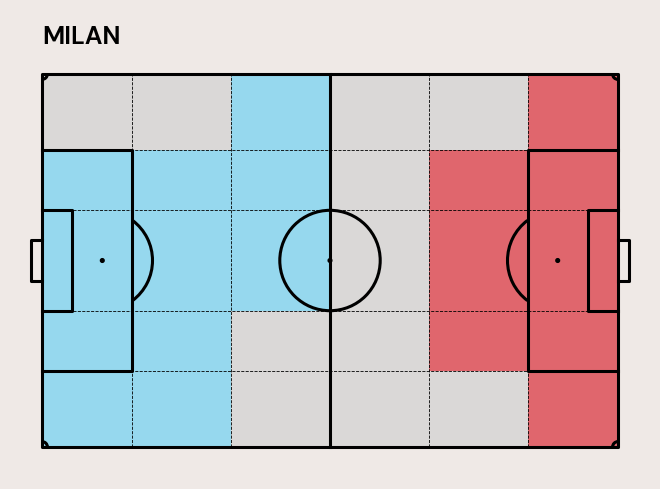

In [7]:
fig = plt.figure(figsize = (4,4), dpi = 200)
ax = plt.subplot(111)
plot_zone_dominance(ax, 120)

In [8]:
team_order = data[['team']].drop_duplicates().sort_values(by='team')
team_order = team_order['team'].to_list()

In [9]:
# Had to do this manually :(
team_logos = [
    8524, 9857, 7801, 8534,
    8535, 8636, 9885, 8543,
    9888, 8564, 6504, 9875,
    8686, 6480, 9882, 7943,
    9881, 9804, 8600, 9876
]

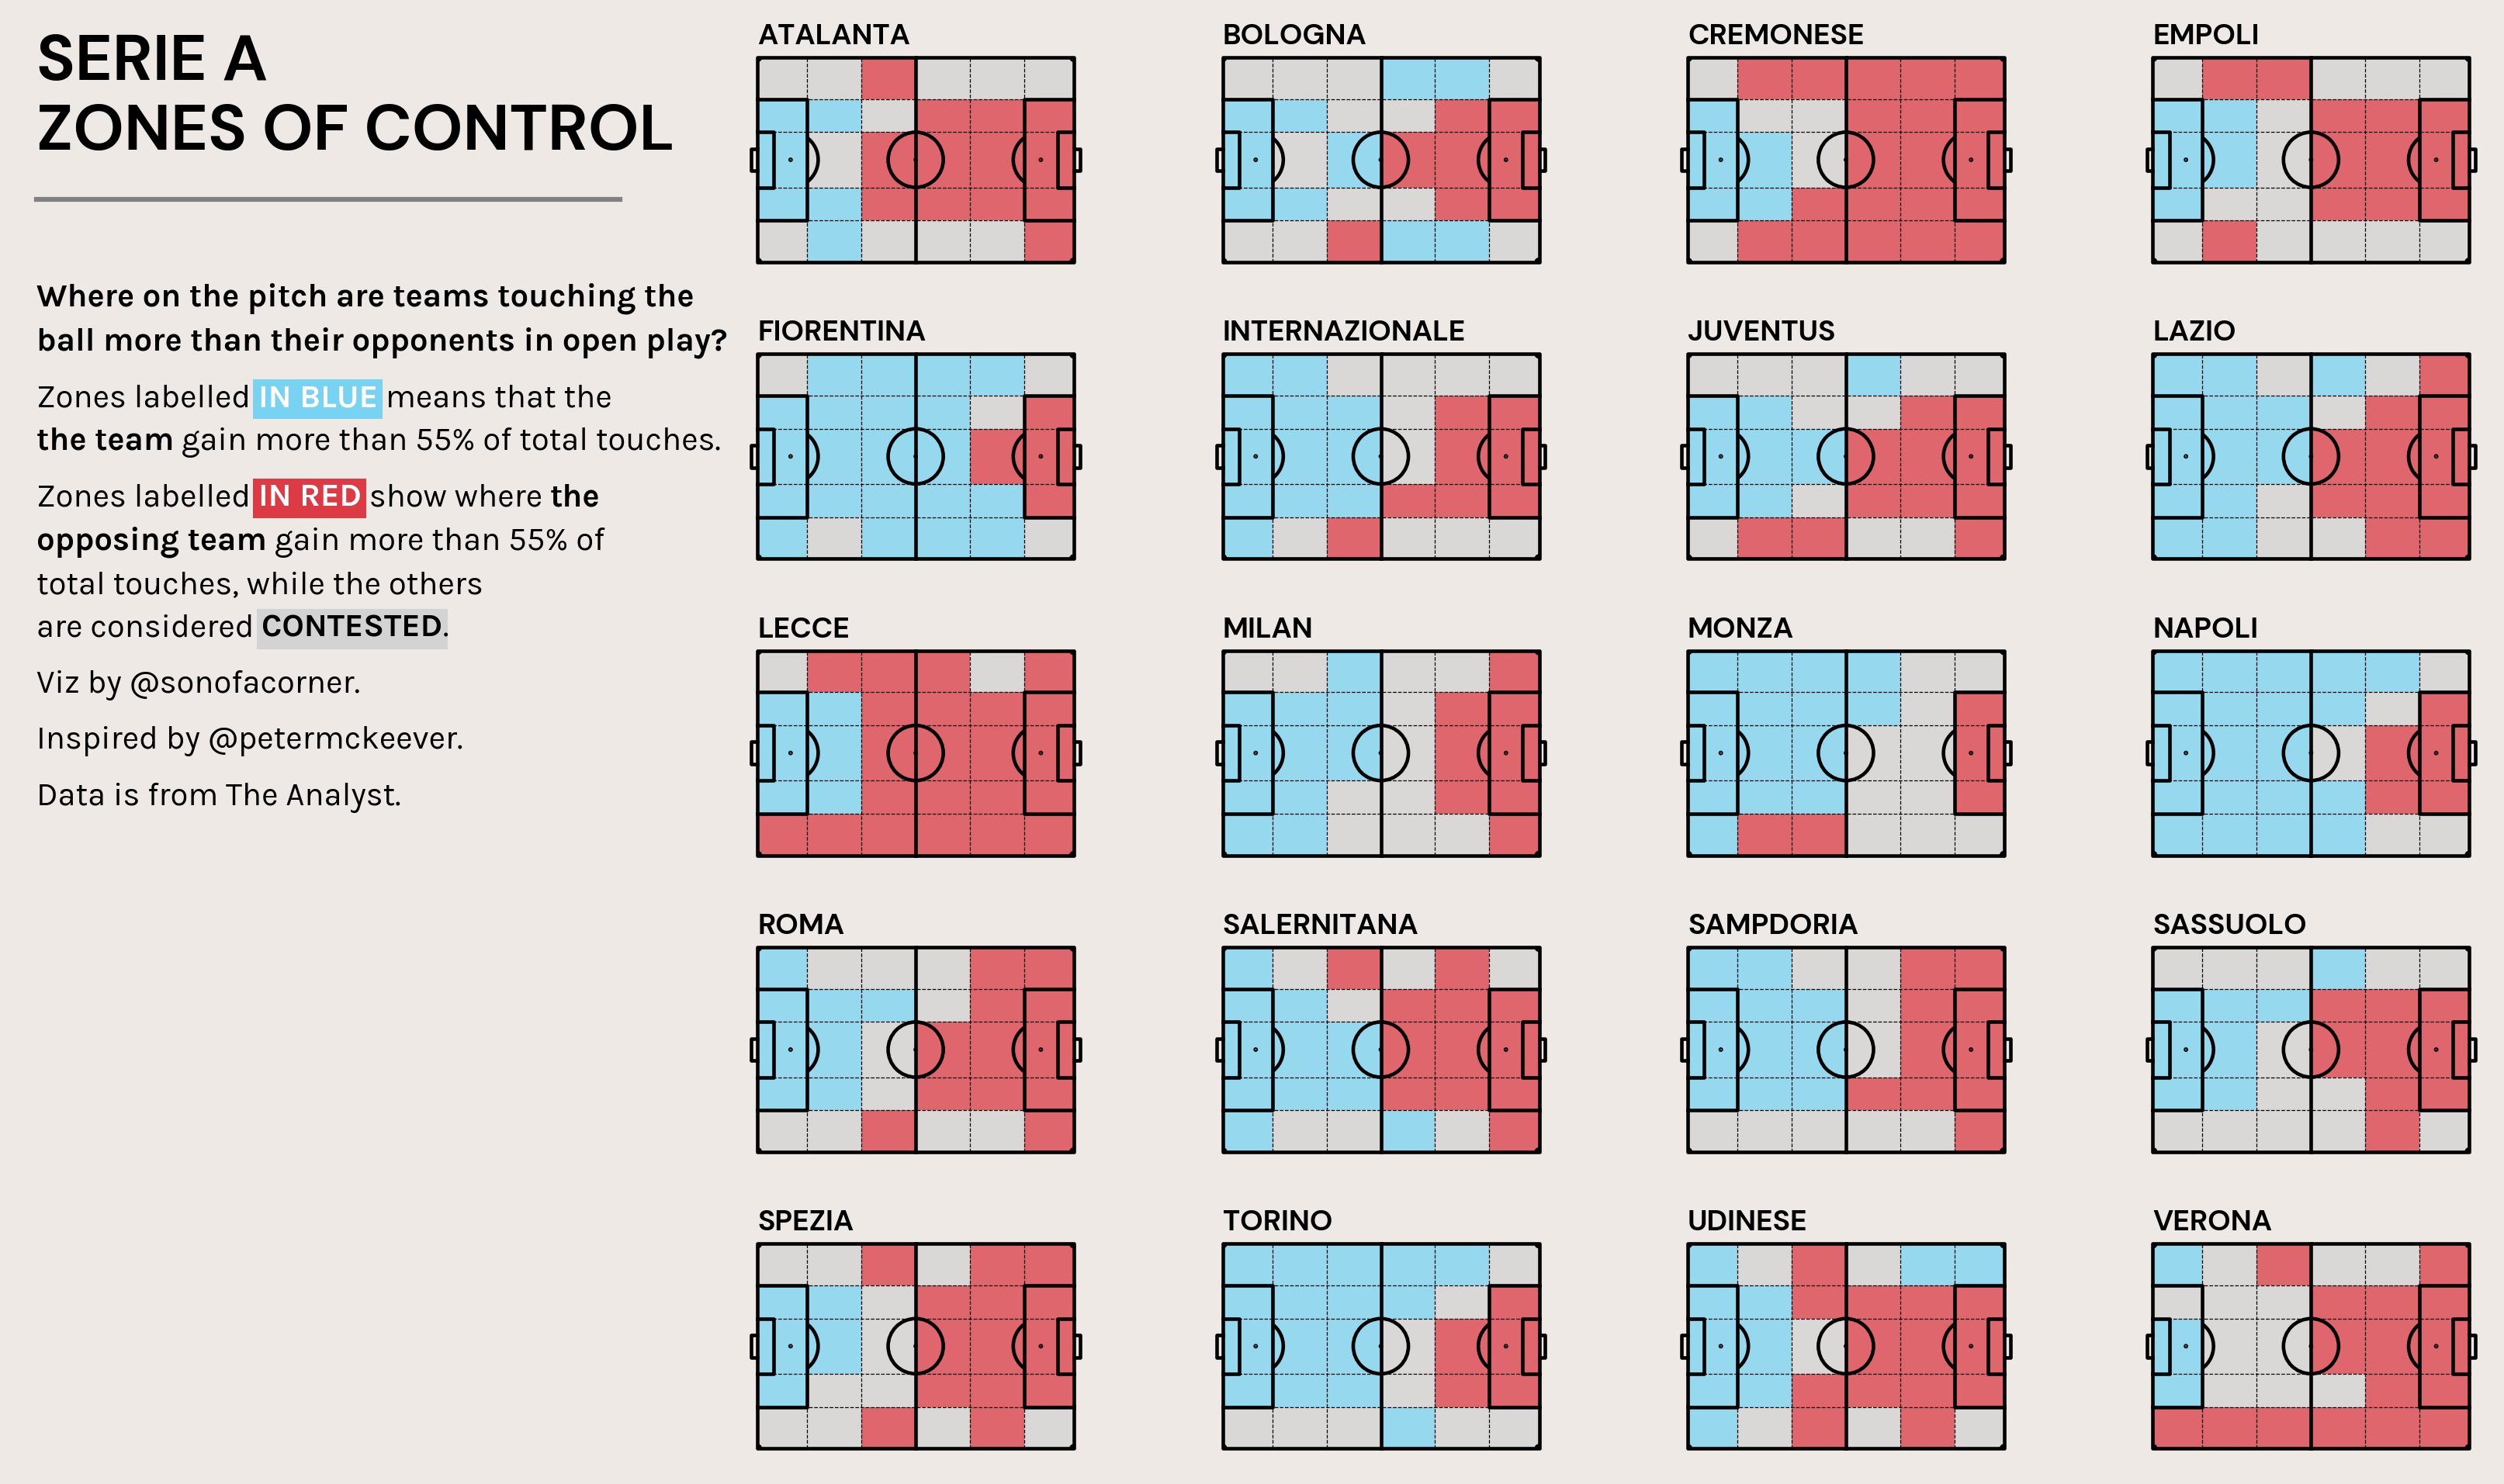

In [16]:
layout = '''
    ABCDE
    AFGHI
    AJKLM
    ANOPQ
    ARSTU
'''

fig = plt.figure(figsize=(15, 8), dpi=300)
ax_dict = fig.subplot_mosaic(layout, gridspec_kw={'wspace': -.45})

counter = 0
for k, ax in ax_dict.items():
    if k == 'A':
        continue
    team_id = data[data['team'] == team_order[counter]]['team_id'].iloc[0]
    plot_zone_dominance(ax, team_id)
    counter += 1

# Chart Legend and Title
ax_dict['A'].set_xlim(0, 1)
ax_dict['A'].set_ylim(0, 1)

ax_dict['A'].annotate(
    xy=(.01, .95),
    text='SERIE A\nZONES OF CONTROL',
    ha='left',
    va='center',
    weight='bold',
    size=20
)
ax_dict['A'].plot(
    [.01, .7],
    [.88, .88],
    color='grey'
)

string_label = '''

<Where on the pitch are teams touching the>
<ball more than their opponents in open play?>

Zones labelled <IN BLUE> means that the
<the team> gain more than 55% of total touches.

Zones labelled <IN RED> show where <the>
<opposing team> gain more than 55% of
total touches, while the others 
are considered <CONTESTED>.

Viz by @sonofacorner.

Inspired by @petermckeever.

Data is from The Analyst.
'''

bbox_pad = 1.5
bboxprops = {'linewidth': 0, 'pad': bbox_pad}

ax_text(
    x=.01, y=.84,
    s=string_label,
    ax=ax_dict['A'],
    family='Karla',
    highlight_textprops=[
        {'weight': 'bold'},
        {'weight': 'bold'},
        {'color': 'w', 'weight': 'bold', 'bbox': {
            'facecolor':color_team, **bboxprops}},
        {'weight': 'bold'},
        {'color': 'w', 'weight': 'bold', 'bbox': {
            'facecolor':color_opp, **bboxprops}},
        {'weight': 'bold'},
        {'weight': 'bold'},
        {'color': 'black', 'weight': 'bold', 'bbox': {
            'facecolor': color_cont, **bboxprops}},
    ]
)

ax_dict['A'].set_axis_off()
